In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import glob

from datetime import datetime, date

## To-do list
- Get clear on accuracy formula and calculations
- Standard deviations
- Optimization
- Repeat using a (non-deep learning) classifier of your choice.
- Discussions

In [20]:
def computeHoG(image, winSize, blockSize, blockStride, cellSize,
                               nbins, RESIZE_DIM, cell_size, block_size):
    
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

    n_cells = (RESIZE_DIM // cell_size[0], RESIZE_DIM // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(image)
    hog_feats = hog_feats.reshape(n_cells[1]-block_size[1]+1,
                                  n_cells[0]-block_size[0]+1,
                                  block_size[0], block_size[1], nbins)
    hog_feats = hog_feats.transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,
    #for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                      off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                       off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count

    gradients = gradients.reshape((1, -1))
    return gradients

def resizeImage(image, dimension):
    imy, imx = image.shape[0:2]
    M = np.float32([[dimension/imx, 0, 0], [0, dimension/imy, 0]])
    image = cv2.warpAffine(image, M, (RESIZE_DIM, RESIZE_DIM))
    return image

In [21]:
""" With limited image count"""

#display
startGlobal = datetime.time(datetime.now())

# #testing
categoriesTest  = [
#      "car",
#      "background",
#      "pickup_truck",
#     "articulated_truck",
#     "bus",
     "work_van",
     "pedestrian",
    "single_unit_truck",
    "bicycle",
    "motorcycle",
    "non-motorized_vehicle"]
#endTesting
#^We notice that runtime is minimized of operations occur on the largest categories first
numCategories = len(categoriesTest)

"""
################################################
 Setting a limit of 2000 images to speed up
 computations and balance proportion of images
################################################
"""

#TEMP
sumIm = 0
for i in range(numCategories):
    path = ("MIO-TCD-Classification/train/%s/*.jpg" % categoriesTest[i])
#     numImages = len(glob.glob(path))
    if len(glob.glob(path)) > 2000: numImages = 2000
    sumIm = sumIm + numImages
#End TEMP

RESIZE_DIM = 64
# totalNumIm = 519164 #MAY GIVE MEMORY ERROR
#testing
totalNumIm = sumIm
#End testing
globalImCtr = 0

#HoG variables
#Raw variables
cell_size = (4,4)
block_size = (4, 4)

#variables for computation
winSize = (RESIZE_DIM // cell_size[1] * cell_size[1], RESIZE_DIM // cell_size[0] * cell_size[0] )
blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
blockStride = (cell_size[1], cell_size[0])
cellSize = (cell_size[1], cell_size[0])
nbins = 8
#End HoG variables

totalNumFeatures = RESIZE_DIM // cell_size[1] * RESIZE_DIM // cell_size[0] * nbins

#array initialization
labelsArray = np.zeros(totalNumIm, dtype=np.int)
featuresArray = np.zeros((totalNumIm, totalNumFeatures))
indexArray = np.arange(totalNumIm, dtype=np.int)
np.random.shuffle(indexArray)         

# Read input images category by category
for i in range(numCategories):
    start = datetime.time(datetime.now())

    #specifying path to images
    path = ("MIO-TCD-Classification/train/%s/*.jpg" % categoriesTest[i])

    #Variable initializations
    categoryImgCnt = 0
    nextPctg = 5
    numImages = len(glob.glob(path))
    if numImages > 2000: numImages = 2000

    #display
    print("Loading Images for category:    >>>" + categoriesTest[i] + "<<<    " + str(numImages) + " images of " 
          + str(len(glob.glob(path))) + " total images")
    print("    Percentage Completed: 0%-", end='')

    # for each image in the category folder
#     for file in glob.glob(path):
    imgCounter = 0
    for file in glob.glob(path):
        if imgCounter < numImages:
            imgCounter += 1
            #read, convert color, get features, stor info
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #resizing IF NECESSARY
            #TRY to do HoG without resizing image. to be discussed
            image = resizeImage(image, RESIZE_DIM)
            #end resize

            #Computing features
            #HoG features
            gradients = computeHoG(image, winSize, blockSize, blockStride, cellSize,
                                   nbins, RESIZE_DIM, cell_size, block_size)

            randomIndex = indexArray[globalImCtr]
            featuresArray[randomIndex] = gradients
            labelsArray[randomIndex] = i
            #End Feature computation

            #variable update
            globalImCtr = globalImCtr + 1
            categoryImgCnt = categoryImgCnt + 1

            #display
            if (int(categoryImgCnt*100/numImages)) == nextPctg:
                print(str(nextPctg) + "%", end='')
                if nextPctg != 100 : print("-", end='')
                nextPctg = nextPctg + 5
        else:
            # dont load more than 2000 imgs
            break
    #display        
    print("")
#     print("loaded " + str(imgCounter) + " images")
    end = datetime.time(datetime.now())
    print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))

#display
endGlobal = datetime.time(datetime.now())
duration = datetime.combine(date.today(), endGlobal) - datetime.combine(date.today(), startGlobal)
print(">Total duration: " + str(duration))
print(labelsArray[:100])

Loading Images for category:    >>>work_van<<<    2000 images of 9679 total images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:10.162977
Loading Images for category:    >>>pedestrian<<<    2000 images of 6262 total images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:07.028699
Loading Images for category:    >>>single_unit_truck<<<    2000 images of 5120 total images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:10.329630
Loading Images for category:    >>>bicycle<<<    2000 images of 2284 total images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:07.019766
Loading Images for category:    >>>motorcycle<<<    1982 images of 1982 total images
    Percentage Comple

In [22]:
print("Size of featuresArray: ", featuresArray.shape)
print("Size of labelsArray: ", labelsArray.shape)

Size of featuresArray:  (12000, 2048)
Size of labelsArray:  (12000,)


Updates:
  Note: 
    This is the deep learning implementation of the classifier.
    In this implementation we use an SVM classifier
    Precision: Of the predictions made for class C, what fraction was correct?
    Recall: ”Of the samples for class C, how many were correctly predicted?

  Classifiers can be loaded if files classifier_0.sav - classifier_9.sav are in the same folder as this .ipynb file.

Would you like to build or load the SVM classifiers? load

  Loading classifier >>classifier_0.sav<<


C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 0
    Duration: 0:00:55.780174
  For subset 0:
    For category work_van: TP=184, FP=55, FN=44, TN=917
      Accuracy = 91.75%      Precision = 76.99%      Recall = 80.70%
    For category pedestrian: TP=162, FP=79, FN=46, TN=913
      Accuracy = 89.58%      Precision = 67.22%      Recall = 77.88%
    For category single_unit_truck: TP=131, FP=44, FN=49, TN=976
      Accuracy = 92.25%      Precision = 74.86%      Recall = 72.78%
    For category bicycle: TP=151, FP=46, FN=70, TN=933
      Accuracy = 90.33%      Precision = 76.65%      Recall = 68.33%
    For category motorcycle: TP=129, FP=55, FN=62, TN=954
      Accuracy = 90.25%      Precision = 70.11%      Recall = 67.54%
    For category non-motorized_vehicle: TP=117, FP=47, FN=55, TN=981
      Accuracy = 91.50%      Precision = 71.34%      Recall = 68.02%
  Average accuracy of subset 0 = 90.94%

  Loading classifier >>classifier_1.sav<<


C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 1
    Duration: 0:00:56.338303
  For subset 1:
    For category work_van: TP=181, FP=47, FN=42, TN=930
      Accuracy = 92.58%      Precision = 79.39%      Recall = 81.17%
    For category pedestrian: TP=155, FP=73, FN=47, TN=925
      Accuracy = 90.00%      Precision = 67.98%      Recall = 76.73%
    For category single_unit_truck: TP=121, FP=50, FN=44, TN=985
      Accuracy = 92.17%      Precision = 70.76%      Recall = 73.33%
    For category bicycle: TP=154, FP=38, FN=78, TN=930
      Accuracy = 90.33%      Precision = 80.21%      Recall = 66.38%
    For category motorcycle: TP=145, FP=62, FN=48, TN=945
      Accuracy = 90.83%      Precision = 70.05%      Recall = 75.13%
    For category non-motorized_vehicle: TP=126, FP=48, FN=59, TN=967
      Accuracy = 91.08%      Precision = 72.41%      Recall = 68.11%
  Average accuracy of subset 1 = 91.17%

  Loading classifier >>classifier_2.sav<<


C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 2
    Duration: 0:00:55.410873
  For subset 2:
    For category work_van: TP=175, FP=52, FN=45, TN=928
      Accuracy = 91.92%      Precision = 77.09%      Recall = 79.55%
    For category pedestrian: TP=145, FP=67, FN=42, TN=946
      Accuracy = 90.92%      Precision = 68.40%      Recall = 77.54%
    For category single_unit_truck: TP=177, FP=38, FN=43, TN=942
      Accuracy = 93.25%      Precision = 82.33%      Recall = 80.45%
    For category bicycle: TP=152, FP=42, FN=61, TN=945
      Accuracy = 91.42%      Precision = 78.35%      Recall = 71.36%
    For category motorcycle: TP=154, FP=55, FN=47, TN=944
      Accuracy = 91.50%      Precision = 73.68%      Recall = 76.62%
    For category non-motorized_vehicle: TP=95, FP=48, FN=64, TN=993
      Accuracy = 90.67%      Precision = 66.43%      Recall = 59.75%
  Average accuracy of subset 2 = 91.61%

  Loading classifier >>classifier_3.sav<<


C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 3
    Duration: 0:00:56.574715
  For subset 3:
    For category work_van: TP=177, FP=58, FN=44, TN=921
      Accuracy = 91.50%      Precision = 75.32%      Recall = 80.09%
    For category pedestrian: TP=168, FP=89, FN=48, TN=895
      Accuracy = 88.58%      Precision = 65.37%      Recall = 77.78%
    For category single_unit_truck: TP=157, FP=42, FN=65, TN=936
      Accuracy = 91.08%      Precision = 78.89%      Recall = 70.72%
    For category bicycle: TP=125, FP=32, FN=63, TN=980
      Accuracy = 92.08%      Precision = 79.62%      Recall = 66.49%
    For category motorcycle: TP=131, FP=52, FN=64, TN=953
      Accuracy = 90.33%      Precision = 71.58%      Recall = 67.18%
    For category non-motorized_vehicle: TP=108, FP=61, FN=50, TN=981
      Accuracy = 90.75%      Precision = 63.91%      Recall = 68.35%
  Average accuracy of subset 3 = 90.72%

  Loading classifier >>classifier_4.sav<<


C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 4
    Duration: 0:00:56.696349
  For subset 4:
    For category work_van: TP=178, FP=52, FN=46, TN=924
      Accuracy = 91.83%      Precision = 77.39%      Recall = 79.46%
    For category pedestrian: TP=152, FP=72, FN=37, TN=939
      Accuracy = 90.92%      Precision = 67.86%      Recall = 80.42%
    For category single_unit_truck: TP=144, FP=54, FN=49, TN=953
      Accuracy = 91.42%      Precision = 72.73%      Recall = 74.61%
    For category bicycle: TP=146, FP=32, FN=46, TN=976
      Accuracy = 93.50%      Precision = 82.02%      Recall = 76.04%
    For category motorcycle: TP=160, FP=44, FN=60, TN=936
      Accuracy = 91.33%      Precision = 78.43%      Recall = 72.73%
    For category non-motorized_vehicle: TP=116, FP=50, FN=66, TN=968
      Accuracy = 90.33%      Precision = 69.88%      Recall = 63.74%
  Average accuracy of subset 4 = 91.56%

  Loading classifier >>classifier_5.sav<<


C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 5
    Duration: 0:01:09.394952
  For subset 5:
    For category work_van: TP=192, FP=56, FN=36, TN=916
      Accuracy = 92.33%      Precision = 77.42%      Recall = 84.21%
    For category pedestrian: TP=163, FP=77, FN=47, TN=913
      Accuracy = 89.67%      Precision = 67.92%      Recall = 77.62%
    For category single_unit_truck: TP=154, FP=33, FN=60, TN=953
      Accuracy = 92.25%      Precision = 82.35%      Recall = 71.96%
    For category bicycle: TP=135, FP=42, FN=57, TN=966
      Accuracy = 91.75%      Precision = 76.27%      Recall = 70.31%
    For category motorcycle: TP=144, FP=46, FN=47, TN=963
      Accuracy = 92.25%      Precision = 75.79%      Recall = 75.39%
    For category non-motorized_vehicle: TP=106, FP=52, FN=59, TN=983
      Accuracy = 90.75%      Precision = 67.09%      Recall = 64.24%
  Average accuracy of subset 5 = 91.50%

  Loading classifier >>classifier_6.sav<<


C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 6
    Duration: 0:00:55.205336
  For subset 6:
    For category work_van: TP=186, FP=48, FN=47, TN=919
      Accuracy = 92.08%      Precision = 79.49%      Recall = 79.83%
    For category pedestrian: TP=156, FP=77, FN=25, TN=942
      Accuracy = 91.50%      Precision = 66.95%      Recall = 86.19%
    For category single_unit_truck: TP=170, FP=49, FN=52, TN=929
      Accuracy = 91.58%      Precision = 77.63%      Recall = 76.58%
    For category bicycle: TP=126, FP=32, FN=58, TN=984
      Accuracy = 92.50%      Precision = 79.75%      Recall = 68.48%
    For category motorcycle: TP=139, FP=54, FN=63, TN=944
      Accuracy = 90.25%      Precision = 72.02%      Recall = 68.81%
    For category non-motorized_vehicle: TP=118, FP=45, FN=60, TN=977
      Accuracy = 91.25%      Precision = 72.39%      Recall = 66.29%
  Average accuracy of subset 6 = 91.53%

  Loading classifier >>classifier_7.sav<<


C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 7
    Duration: 0:00:53.810067
  For subset 7:
    For category work_van: TP=202, FP=55, FN=40, TN=903
      Accuracy = 92.08%      Precision = 78.60%      Recall = 83.47%
    For category pedestrian: TP=177, FP=81, FN=38, TN=904
      Accuracy = 90.08%      Precision = 68.60%      Recall = 82.33%
    For category single_unit_truck: TP=140, FP=45, FN=45, TN=970
      Accuracy = 92.50%      Precision = 75.68%      Recall = 75.68%
    For category bicycle: TP=131, FP=36, FN=64, TN=969
      Accuracy = 91.67%      Precision = 78.44%      Recall = 67.18%
    For category motorcycle: TP=124, FP=61, FN=65, TN=950
      Accuracy = 89.50%      Precision = 67.03%      Recall = 65.61%
    For category non-motorized_vehicle: TP=111, FP=37, FN=63, TN=989
      Accuracy = 91.67%      Precision = 75.00%      Recall = 63.79%
  Average accuracy of subset 7 = 91.25%

  Loading classifier >>classifier_8.sav<<


C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 8
    Duration: 0:00:56.596194
  For subset 8:
    For category work_van: TP=190, FP=61, FN=34, TN=915
      Accuracy = 92.08%      Precision = 75.70%      Recall = 84.82%
    For category pedestrian: TP=160, FP=64, FN=30, TN=946
      Accuracy = 92.17%      Precision = 71.43%      Recall = 84.21%
    For category single_unit_truck: TP=150, FP=44, FN=56, TN=950
      Accuracy = 91.67%      Precision = 77.32%      Recall = 72.82%
    For category bicycle: TP=127, FP=41, FN=54, TN=978
      Accuracy = 92.08%      Precision = 75.60%      Recall = 70.17%
    For category motorcycle: TP=153, FP=43, FN=59, TN=945
      Accuracy = 91.50%      Precision = 78.06%      Recall = 72.17%
    For category non-motorized_vehicle: TP=123, FP=44, FN=64, TN=969
      Accuracy = 91.00%      Precision = 73.65%      Recall = 65.78%
  Average accuracy of subset 8 = 91.75%

  Loading classifier >>classifier_9.sav<<


C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 9
    Duration: 0:00:57.631113
  For subset 9:
    For category work_van: TP=182, FP=49, FN=42, TN=927
      Accuracy = 92.42%      Precision = 78.79%      Recall = 81.25%
    For category pedestrian: TP=154, FP=73, FN=48, TN=925
      Accuracy = 89.92%      Precision = 67.84%      Recall = 76.24%
    For category single_unit_truck: TP=140, FP=47, FN=53, TN=960
      Accuracy = 91.67%      Precision = 74.87%      Recall = 72.54%
    For category bicycle: TP=150, FP=38, FN=52, TN=960
      Accuracy = 92.50%      Precision = 79.79%      Recall = 74.26%
    For category motorcycle: TP=129, FP=66, FN=59, TN=946
      Accuracy = 89.58%      Precision = 66.15%      Recall = 68.62%
    For category non-motorized_vehicle: TP=121, FP=51, FN=70, TN=958
      Accuracy = 89.92%      Precision = 70.35%      Recall = 63.35%
  Average accuracy of subset 9 = 91.00%
  Creating confusion matrix 9
    Duration: 0:00:00.005984


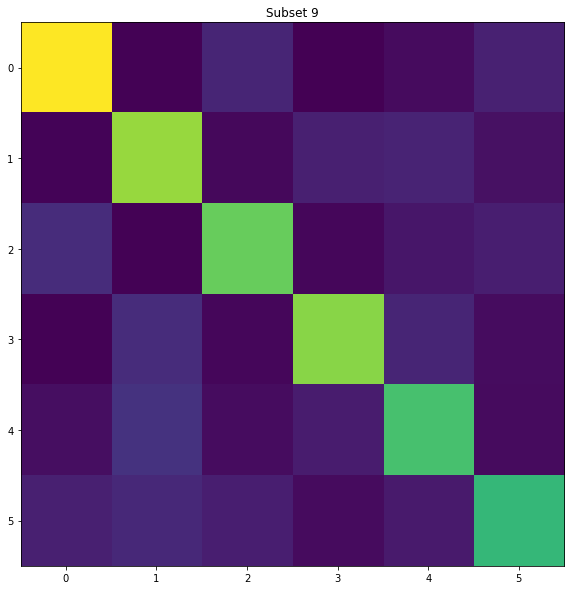

Legend:
  0: work_van
  1: pedestrian
  2: single_unit_truck
  3: bicycle
  4: motorcycle
  5: non-motorized_vehicle

Overall average accuracy is 91.30%
Standard deviation is 0.003205

Done, total duration: 0:09:40.033663


In [18]:
print("Updates:")

print("  Note: ")
print("    This is the deep learning implementation of the classifier.")
print("    In this implementation we use an SVM classifier")
print("    Precision: Of the predictions made for class C, what fraction was correct?")
print("    Recall: ”Of the samples for class C, how many were correctly predicted?\n")
print("  Classifiers can be loaded if files classifier_0.sav - classifier_9.sav are in the same" 
     + " folder as this .ipynb file.\n")

realStart = datetime.time(datetime.now())

numSubset = 10

subsetSize = featuresArray.shape[0]//numSubset
    
accuracyArray = []

sqrdDiff = []

while(1):
    inputStr = input("Would you like to build or load the SVM classifiers? ")
    
    inputStr = inputStr.lower()
    
    if inputStr == 'exit':
        print("  Program exiting\n")
        break
    
    elif inputStr == 'help':
        print("  Available commands: Build, Load, Help, Exit\n")
    
    elif inputStr == 'build' or inputStr == 'load':
        # proceed and build or load classifiers
        realStart = datetime.time(datetime.now())
       
        for subsetIndex in range(numSubset):
            data_test = featuresArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
            labels_test = labelsArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
    
            data_train = np.concatenate((featuresArray[:subsetIndex*subsetSize], 
                                         featuresArray[(subsetIndex+1)*subsetSize:]), axis = 0)
            labels_train = np.concatenate((labelsArray[:subsetIndex*subsetSize], 
                                           labelsArray[(subsetIndex+1)*subsetSize:]), axis = 0)
    
        #     print("data_train shape:", data_train.shape)
        #     print("d")
    
            ################################################
            """Building the classifiers"""
            if inputStr == 'build':
                while(subsetIndex==0):
                    inputSave = input("  Would you like to save the classifiers? ")
                    inputSave = inputSave.lower()
                    
                    if inputSave == 'no':
                        save = 0
                        print("    Classifiers will not be saved\n")
                        break
                    
                    elif inputSave == 'yes':
                        save = 1
                        print("    Classifiers will be saved\n")
                        break
                    
                    else:
                        print("    Invalid input -> 'yes' or 'no'\n")
                    
                print("\n  Creating classifier " + str(subsetIndex))
                start = datetime.time(datetime.now())
                clf = svm.SVC(C = 100.) # default kernel='rfb'
                clf.fit(data_train, labels_train)
                end = datetime.time(datetime.now())
                print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
                
                """Saving the classifiers"""
                if save == 1:
                    filename = ('classifier_%i.sav' % subsetIndex)
                    print("  Saving classifier " + str(subsetIndex) + " as >>" + filename + "<<")
                    joblib.dump(clf, filename)

            ################################################
            
            ################################################
            
            elif inputStr == 'load':
                """Loading the classifiers"""
                filename = ('classifier_%i.sav' % subsetIndex)
                print("\n  Loading classifier >>" + filename + "<<")
                clf = joblib.load(filename)
            ################################################
    
            print("  Getting predictions for classifier " + str(subsetIndex))
            start = datetime.time(datetime.now())
            prediction = clf.predict(data_test)
            end = datetime.time(datetime.now())
            print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
            # Precision
            # for each class, get the precision (then average of all classes for all subset?)
            print("  For subset " + str(subsetIndex) + ":")
    
        #     print("prediction shape:", prediction.shape)
    
            totalTP = 0
            totalTN = 0
    
            for category in range(numCategories):
                TP = 0
                FP = 0
                FN = 0
                TN = 0
                for n in range(len(prediction)):
                    if prediction[n] == category:
                        if labels_test[n] == category:
                            # got a true positive
                            TP += 1
                            totalTP += 1
                        else:
                            # got a false positive
                            FP += 1
                        continue
    
                    if prediction[n] != category:
                        if labels_test[n] == category:
                            # got a false negative
                            FN += 1
                        else:
                            # got a true negative
                            TN += 1
                            totalTN += 1
                        continue
    
                    else: print("    Error at n=" + str(n) + "-> Predicted: " + str(prediction[n])
                                + ", Correct: " + str(labels_test[n]))
    
                print("    For category " + str(categoriesTest[category]) + ": TP=" + str(TP) + ", FP=" + str(FP) 
                      + ", FN=" + str(FN) + ", TN=" + str(TN))
    
                accuracyCalc = (TP+TN)/(TP+TN+FP+FN)*100
                precision = TP/(TP+FP)*100
                recall = TP/(TP+FN)*100
    
                print("      Accuracy = %.2f" % accuracyCalc + "%", end='')
                print("      Precision = %.2f" % precision + "%", end='')
                print("      Recall = %.2f" % recall + "%")
    
            subAcc = (totalTP+totalTN)/len(prediction)*100/numCategories
            print("  Average accuracy of subset %i = %.2f" % (subsetIndex, subAcc) + "%")
            accuracyArray.append(subAcc)
    
            # Confusion Matrix for last subset only
            ################################################
            # Do we only need one?
            ################################################
            if subsetIndex == numSubset-1:
                print("  Creating confusion matrix " + str(subsetIndex))
                start = datetime.time(datetime.now())
                confMat = confusion_matrix(labels_test, prediction)
                end = datetime.time(datetime.now())
                print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
                plt.figure(figsize=(10,10))
                plt.imshow(confMat), plt.title("Subset " + str(subsetIndex))
                plt.show()
    
                # display categories and their label
                print("Legend:")
                for cat in range(len(categoriesTest)):
                    print("  " + str(cat) + ": " + str(categoriesTest[cat]))
    
        # calculate the overall average accuracy
        avgAccuracy = 0
        avgAccuracy = np.sum(accuracyArray)/len(accuracyArray)
        print("\nOverall average accuracy is %.2f" % (avgAccuracy) + "%")
        
        # calculate the standard deviation
        accArray = np.asarray(accuracyArray)
        sqrdDiff = ((accArray-avgAccuracy)/100)**2
        stdDev = np.sqrt(np.sum(sqrdDiff)/len(sqrdDiff))
        print("Standard deviation is %f" % stdDev)
    
        realEnd = datetime.time(datetime.now())
        print("\nDone, total duration: " + str(datetime.combine(date.today(), realEnd) 
                                               - datetime.combine(date.today(), realStart)))
        break
    
    else:
        # not a valid input
        print("  '" + inputStr + "' is not a valid input -> type 'help' for help\n")

Updates:
  Note: 
    This is the non-deep learning implementation of the classifier.
    In this implementation we use a kneighbor classifier
    Precision: Of the predictions made for class C, what fraction was correct?
    Recall: ”Of the samples for class C, how many were correctly predicted?

  Classifiers can be loaded if files kNeighborsclassifier_0.sav - kNeighborsclassifier_9.sav are in the same folder as this .ipynb file.

Would you like to build or load the kNeighbors classifiers? load

  Loading classifier >>kNeighborsclassifier_0.sav<<
  Getting predictions for classifier 0
    Duration: 0:01:42.414005
  For subset 0:
    For category work_van: TP=207, FP=73, FN=15, TN=905
      Accuracy = 92.67%      Precision = 73.93%      Recall = 93.24%
    For category pedestrian: TP=130, FP=33, FN=70, TN=967
      Accuracy = 91.42%      Precision = 79.75%      Recall = 65.00%
    For category single_unit_truck: TP=165, FP=47, FN=35, TN=953
      Accuracy = 93.17%      Precision = 77.

    Duration: 0:01:15.813210
  For subset 8:
    For category work_van: TP=223, FP=79, FN=6, TN=892
      Accuracy = 92.92%      Precision = 73.84%      Recall = 97.38%
    For category pedestrian: TP=138, FP=27, FN=68, TN=967
      Accuracy = 92.08%      Precision = 83.64%      Recall = 66.99%
    For category single_unit_truck: TP=147, FP=43, FN=44, TN=966
      Accuracy = 92.75%      Precision = 77.37%      Recall = 76.96%
    For category bicycle: TP=158, FP=38, FN=53, TN=951
      Accuracy = 92.42%      Precision = 80.61%      Recall = 74.88%
    For category motorcycle: TP=158, FP=39, FN=22, TN=981
      Accuracy = 94.92%      Precision = 80.20%      Recall = 87.78%
    For category non-motorized_vehicle: TP=138, FP=12, FN=45, TN=1005
      Accuracy = 95.25%      Precision = 92.00%      Recall = 75.41%
  Average accuracy of subset 8 = 93.39%

  Loading classifier >>kNeighborsclassifier_9.sav<<
  Getting predictions for classifier 9
    Duration: 0:01:18.334497
  For subset 9:
   

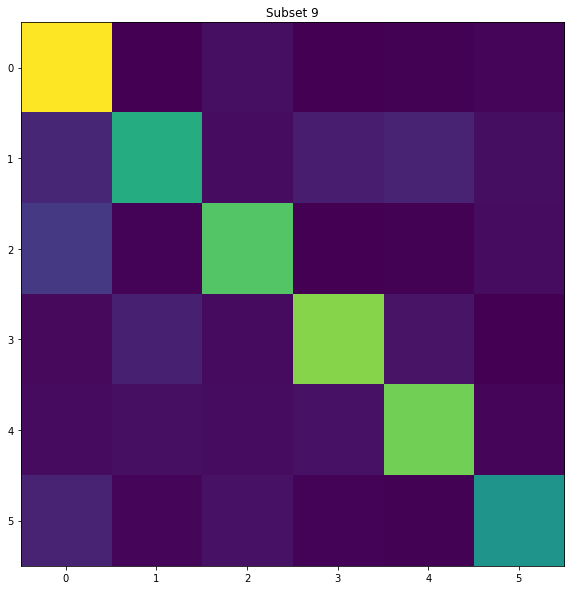

Legend:
  0: work_van
  1: pedestrian
  2: single_unit_truck
  3: bicycle
  4: motorcycle
  5: non-motorized_vehicle

Overall average accuracy is 93.39%
Standard deviation is 0.002480

Done, total duration: 0:36:16.550399


In [24]:
print("Updates:")

print("  Note: ")
print("    This is the non-deep learning implementation of the classifier.")
print("    In this implementation we use a kneighbor classifier")
print("    Precision: Of the predictions made for class C, what fraction was correct?")
print("    Recall: ”Of the samples for class C, how many were correctly predicted?\n")
print("  Classifiers can be loaded if files kNeighborsclassifier_0.sav - kNeighborsclassifier_9.sav are in the same" 
     + " folder as this .ipynb file.\n")

realStart = datetime.time(datetime.now())

numSubset = 10

subsetSize = featuresArray.shape[0]//numSubset
    
accuracyArray = []

sqrdDiff = []

while(1):
    inputStr = input("Would you like to build or load the kNeighbors classifiers? ")
    
    inputStr = inputStr.lower()
    
    if inputStr == 'exit':
        print("  Program exiting\n")
        break
    
    elif inputStr == 'help':
        print("  Available commands: Build, Load, Help, Exit\n")
    
    elif inputStr == 'build' or inputStr == 'load':
        # proceed and build or load classifiers
        realStart = datetime.time(datetime.now())
       
        for subsetIndex in range(numSubset):
            data_test = featuresArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
            labels_test = labelsArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
    
            data_train = np.concatenate((featuresArray[:subsetIndex*subsetSize], 
                                         featuresArray[(subsetIndex+1)*subsetSize:]), axis = 0)
            labels_train = np.concatenate((labelsArray[:subsetIndex*subsetSize], 
                                           labelsArray[(subsetIndex+1)*subsetSize:]), axis = 0)
    
        #     print("data_train shape:", data_train.shape)
        #     print("d")
    
            ################################################
            """Building the classifiers"""
            if inputStr == 'build':
                while(subsetIndex==0):
                    inputSave = input("  Would you like to save the classifiers? ")
                    inputSave = inputSave.lower()
                    
                    if inputSave == 'no':
                        save = 0
                        print("    Classifiers will not be saved\n")
                        break
                    
                    elif inputSave == 'yes':
                        save = 1
                        print("    Classifiers will be saved\n")
                        break
                    
                    else:
                        print("    Invalid input -> 'yes' or 'no'\n")
                    
                print("\n  Creating classifier " + str(subsetIndex))
                start = datetime.time(datetime.now())
                clf_kneighbors = neighbors.KNeighborsClassifier(3)
                clf_kneighbors.fit(data_train, labels_train)
                end = datetime.time(datetime.now())
                print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
                
                """Saving the classifiers"""
                if save == 1:
                    filename = ('kNeighborsclassifier_%i.sav' % subsetIndex)
                    print("  Saving classifier " + str(subsetIndex) + " as >>" + filename + "<<")
                    joblib.dump(clf_kneighbors, filename)

            ################################################
            
            ################################################
            
            elif inputStr == 'load':
                """Loading the classifiers"""
                filename = ('kNeighborsclassifier_%i.sav' % subsetIndex)
                print("\n  Loading classifier >>" + filename + "<<")
                clf_kneighbors = joblib.load(filename)
            ################################################
    
            print("  Getting predictions for classifier " + str(subsetIndex))
            start = datetime.time(datetime.now())
            prediction = clf_kneighbors.predict(data_test)
            end = datetime.time(datetime.now())
            print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
            # Precision
            # for each class, get the precision (then average of all classes for all subset?)
            print("  For subset " + str(subsetIndex) + ":")
    
        #     print("prediction shape:", prediction.shape)
    
            totalTP = 0
            totalTN = 0
    
            for category in range(numCategories):
                TP = 0
                FP = 0
                FN = 0
                TN = 0
                for n in range(len(prediction)):
                    if prediction[n] == category:
                        if labels_test[n] == category:
                            # got a true positive
                            TP += 1
                            totalTP += 1
                        else:
                            # got a false positive
                            FP += 1
                        continue
    
                    if prediction[n] != category:
                        if labels_test[n] == category:
                            # got a false negative
                            FN += 1
                        else:
                            # got a true negative
                            TN += 1
                            totalTN += 1
                        continue
    
                    else: print("    Error at n=" + str(n) + "-> Predicted: " + str(prediction[n])
                                + ", Correct: " + str(labels_test[n]))
    
                print("    For category " + str(categoriesTest[category]) + ": TP=" + str(TP) + ", FP=" + str(FP) 
                      + ", FN=" + str(FN) + ", TN=" + str(TN))
    
                accuracyCalc = (TP+TN)/(TP+TN+FP+FN)*100
                precision = TP/(TP+FP)*100
                recall = TP/(TP+FN)*100
    
                print("      Accuracy = %.2f" % accuracyCalc + "%", end='')
                print("      Precision = %.2f" % precision + "%", end='')
                print("      Recall = %.2f" % recall + "%")
    
            subAcc = (totalTP+totalTN)/len(prediction)*100/numCategories
            print("  Average accuracy of subset %i = %.2f" % (subsetIndex, subAcc) + "%")
            accuracyArray.append(subAcc)
    
            # Confusion Matrix for last subset only
            ################################################
            # Do we only need one?
            ################################################
            if subsetIndex == numSubset-1:
                print("  Creating confusion matrix " + str(subsetIndex))
                start = datetime.time(datetime.now())
                confMat = confusion_matrix(labels_test, prediction)
                end = datetime.time(datetime.now())
                print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
                plt.figure(figsize=(10,10))
                plt.imshow(confMat), plt.title("Subset " + str(subsetIndex))
                plt.show()
    
                # display categories and their label
                print("Legend:")
                for cat in range(len(categoriesTest)):
                    print("  " + str(cat) + ": " + str(categoriesTest[cat]))
    
        # calculate the overall average accuracy
        avgAccuracy = 0
        avgAccuracy = np.sum(accuracyArray)/len(accuracyArray)
        print("\nOverall average accuracy is %.2f" % (avgAccuracy) + "%")
        
        # calculate the standard deviation
        accArray = np.asarray(accuracyArray)
        sqrdDiff = ((accArray-avgAccuracy)/100)**2
        stdDev = np.sqrt(np.sum(sqrdDiff)/len(sqrdDiff))
        print("Standard deviation is %f" % stdDev)
    
        realEnd = datetime.time(datetime.now())
        print("\nDone, total duration: " + str(datetime.combine(date.today(), realEnd) 
                                               - datetime.combine(date.today(), realStart)))
        break
    
    else:
        # not a valid input
        print("  '" + inputStr + "' is not a valid input -> type 'help' for help\n")
    
    